<a href="https://colab.research.google.com/github/jha-vineet69/Car-Damage-Detection/blob/main/Car_Damage_Detection_Step_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Libraries

import os
import glob
import datetime
import numpy as np
import h5py
import json
import pickle
import time
import urllib.request

# keras imports
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model

# imports required packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# other imports
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Create a dictionary with configuration/setup we will be using

config={
  "model"           : "vgg16",
  "weights"         : "imagenet",
  "include_top"     : False,

  "train_path"      : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/data1a/training",
  "test_path"       : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/data1a/validation",
  "features_path"   : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/features.h5",
  "labels_path"     : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/labels.h5",
  "results"         : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/results.txt",
  "classifier_path" : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/classifier.pickle",
  "model_path"      : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/model",

  "test_size"       : 0.20,
  "seed"            : 9,
  "num_classes"     : 2
}

In [ ]:
# config variables
model_name    = config["model"]
weights     = config["weights"]
include_top   = config["include_top"]
train_path    = config["train_path"]
features_path   = config["features_path"]
labels_path   = config["labels_path"]
test_size     = config["test_size"]
results     = config["results"]
model_path    = config["model_path"]

In [ ]:
# Here we are loading the base VGG16 model with weights and then excluding the top dense layer
if model_name == "vgg16":
    base_model = VGG16(weights=weights)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    image_size = (224, 224)
else:
    base_model = None

print ("Successfully loaded base model and model...")

553467904/553467096 [==============================] - 5s 0us/step
Successfully loaded base model and model...


In [ ]:
# path to training dataset
train_labels = os.listdir(train_path)

# encode the labels
print ("Encoding labels...")
le = LabelEncoder()
le.fit([tl for tl in train_labels])

# variables to hold features and labels
features = []
labels   = []

# loop over all the labels in the folder
count = 1
for i, label in enumerate(train_labels):
    cur_path = train_path + "/" + label
    count = 1
    print ("Processing...")
    for image_path in glob.glob(cur_path + "/*.jpg"):
        img = image.load_img(image_path, target_size=image_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x)
        flat = feature.flatten()
        features.append(flat)
        labels.append(label)
        count += 1
    print ("Completed label - " + label)

# encode the labels using LabelEncoder
le = LabelEncoder()
le_labels = le.fit_transform(labels)

# get the shape of training labels
print ("Training labels: {}".format(le_labels))
print ("Training labels shape: {}".format(le_labels.shape))

Encoding labels...
Processing...
Completed label - 01-whole
Training labels: [0 0 0 ... 1 1 1]
Training labels shape: (1840,)


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# save features and labels
h5f_data = h5py.File(features_path, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(features))

h5f_label = h5py.File(labels_path, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(le_labels))

h5f_data.close()
h5f_label.close()

# save model and weights
model_json = model.to_json()
with open(model_path + str(test_size) + ".json", "w") as json_file:
    json_file.write(model_json)

# save weights
model.save_weights(model_path + str(test_size) + ".h5")
print("Saved model and weights to disk.")

print ("Features and labels saved.")

Saved model and weights to disk.
Features and labels saved.


In [ ]:
# config variables
test_size     = config["test_size"]
seed      = config["seed"]
features_path   = config["features_path"]
labels_path   = config["labels_path"]
classifier_path = config["classifier_path"]

In [ ]:
# import features and labels
h5f_data  = h5py.File(features_path, 'r')
h5f_label = h5py.File(labels_path, 'r')

features_string = h5f_data['dataset_1']
labels_string   = h5f_label['dataset_1']

features = np.array(features_string)
labels   = np.array(labels_string)

h5f_data.close()
h5f_label.close()

In [ ]:
labels.shape

(1840,)

In [ ]:
# verify the shape of features and labels
print ("[INFO] features shape: {}".format(features.shape))
print ("[INFO] labels shape: {}".format(labels.shape))

print ("[INFO] training started...")
# split the training and testing data
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(features),
                                                                  np.array(labels),
                                                                  test_size=test_size,
                                                                  random_state=seed)

print ("[INFO] splitted train and test data...")
print ("[INFO] train data  : {}".format(trainData.shape))
print ("[INFO] test data   : {}".format(testData.shape))
print ("[INFO] train labels: {}".format(trainLabels.shape))
print ("[INFO] test labels : {}".format(testLabels.shape))

[INFO] features shape: (1840, 4096)
[INFO] labels shape: (1840,)
[INFO] training started...
[INFO] splitted train and test data...
[INFO] train data  : (1472, 4096)
[INFO] test data   : (368, 4096)
[INFO] train labels: (1472,)
[INFO] test labels : (368,)


In [ ]:
# use logistic regression as the model
print ("[INFO] creating model...")
model = LogisticRegression(random_state=seed)
model.fit(trainData, trainLabels)

[INFO] creating model...


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=9, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# evaluate the model of test data
preds = model.predict(testData)

In [ ]:
# dump classifier to file
print ("[INFO] saving model...")
pickle.dump(model, open(classifier_path, 'wb'))

[INFO] saving model...


In [ ]:
# display the confusion matrix
print ("[INFO] confusion matrix")

# plot the confusion matrix
cm = confusion_matrix(testLabels, preds)

[INFO] confusion matrix


In [ ]:
cm

array([[172,  14],
       [ 19, 163]])

In [ ]:
accuracy = ((368-(14+19))/368)*100
accuracy

91.03260869565217

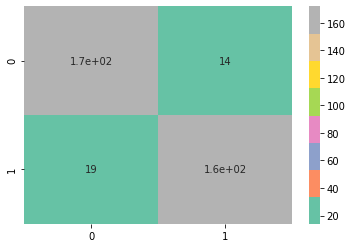

In [ ]:
sns.heatmap(cm, annot=True, cmap="Set2")
plt.show()

In [ ]:
# load the trained logistic regression classifier
print ("[INFO] loading the classifier...")
classifier = pickle.load(open(config["classifier_path"], 'rb'))

# pretrained models needed to perform feature extraction on test data too!
if config["model"] == "vgg16":
	base_model = VGG16(weights=config["weights"])
	model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
	image_size = (224, 224)

else:
	base_model = None

[INFO] loading the classifier...


In [ ]:
def pipe2(image_path, model, classifier):
    urllib.request.urlretrieve(image_path, 'image.jpg')
    img = image.load_img('image.jpg', target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    flat = feature.flatten()
    flat = np.expand_dims(flat, axis=0)
    preds = classifier.predict(flat)
    print("Validating that damage exists....")
    if(preds[0]==0):
        print("Validation complete - Car is found to be damaged. Proceed to location and severity determination!!")
    else:
        print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print ("Hint: Try zooming in/out, using a different angle or different lighting")      

In [ ]:
pipe2('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG', model, classifier)

Validating that damage exists....
Validation complete - Car is found to be damaged. Proceed to location and severity determination!!


In [ ]:
pipe2('https://www.hdnicewallpapers.com/Walls/Big/Rolls%20Royce/2018_Rolls_Royce_Ghost_Series_II_Black_Car.jpg', model, classifier)

Validating that damage exists....
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


In [ ]:
pipe2('https://www.side.cr/wp-content/uploads/2018/09/Connecticut-Sell-Damaged-Car.jpg', model, classifier)

Validating that damage exists....
Validation complete - Car is found to be damaged. Proceed to location and severity determination!!
